In [162]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math
from keras.layers.regularization.dropout import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

%matplotlib inline

## Data Retreival/Formatting

In [2]:
# alpaca_api_key = os.getenv("ALPACA_API_KEY")
# alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [3]:
# type(alpaca_api_key)

In [4]:
crypto_client = CryptoHistoricalDataClient()

In [5]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["ETH/USD"],
    timeframe=TimeFrame.Minute, start='2022-06-30 00:00:00'
)

eth_bars = crypto_client.get_crypto_bars(request_params)

eth_df = eth_bars.df

eth_df

open    high     low   close  volume  \
symbol  timestamp                                                           
ETH/USD 2022-06-30 00:00:00+00:00  1097.4  1097.8  1097.4  1097.8   5.466   
        2022-06-30 00:01:00+00:00  1097.6  1097.6  1097.6  1097.6   0.456   
        2022-06-30 00:02:00+00:00  1097.5  1097.5  1096.8  1096.8   0.685   
        2022-06-30 00:03:00+00:00  1096.5  1103.5  1096.5  1103.5  63.758   
        2022-06-30 00:04:00+00:00  1101.9  1101.9  1101.9  1101.9   2.506   
...                                   ...     ...     ...     ...     ...   
        2022-10-03 02:23:00+00:00  1292.2  1292.3  1292.1  1292.2   3.919   
        2022-10-03 02:24:00+00:00  1292.2  1292.3  1292.1  1292.2   4.855   
        2022-10-03 02:25:00+00:00  1292.2  1293.5  1292.1  1293.5   7.382   
        2022-10-03 02:26:00+00:00  1293.1  1293.1  1292.6  1292.6   0.173   
        2022-10-03 02:27:00+00:00  1292.5  1292.8  1292.5  1292.6  11.419   

                                   trade_count         vwap  
symbol  timestamp                                            
ETH/USD 2022-06-30 00:00:00+00:00          4.0  1097.592682  
        2022-06-30 00:01:00+00:00          1.0  1097.600000  
        2022-06-30 00:02:00+00:00          3.0  1096.801022  
        2022-06-30 00:03:00+00:00         50.0  1100.825691  
        2022-06-30 00:04:00+00:00          1.0  1101.900000  
...                                        ...          ...  
        2022-10-03 02:23:00+00:00         12.0  1292.101174  
        2022-10-03 02:24:00+00:00         10.0  1292.260165  
        2022-10-03 02:25:00+00:00         20.0  1292.163790  
        2022-10-03 02:26:00+00:00          6.0  1293.071676  
        2022-10-03 02:27:00+00:00         17.0  1292.640459  

[130063 rows x 7 columns]

In [6]:
eth_df.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
trade_count    float64
vwap           float64
dtype: object

In [7]:
eth_df = eth_df.reset_index()
eth_df = eth_df.set_index('timestamp')
eth_df = eth_df.drop(columns=['symbol'])

eth_df

open    high     low   close  volume  \
timestamp                                                           
2022-06-30 00:00:00+00:00  1097.4  1097.8  1097.4  1097.8   5.466   
2022-06-30 00:01:00+00:00  1097.6  1097.6  1097.6  1097.6   0.456   
2022-06-30 00:02:00+00:00  1097.5  1097.5  1096.8  1096.8   0.685   
2022-06-30 00:03:00+00:00  1096.5  1103.5  1096.5  1103.5  63.758   
2022-06-30 00:04:00+00:00  1101.9  1101.9  1101.9  1101.9   2.506   
...                           ...     ...     ...     ...     ...   
2022-10-03 02:23:00+00:00  1292.2  1292.3  1292.1  1292.2   3.919   
2022-10-03 02:24:00+00:00  1292.2  1292.3  1292.1  1292.2   4.855   
2022-10-03 02:25:00+00:00  1292.2  1293.5  1292.1  1293.5   7.382   
2022-10-03 02:26:00+00:00  1293.1  1293.1  1292.6  1292.6   0.173   
2022-10-03 02:27:00+00:00  1292.5  1292.8  1292.5  1292.6  11.419   

                           trade_count         vwap  
timestamp                                            
2022-06-30 00:00:00+00:00          4.0  1097.592682  
2022-06-30 00:01:00+00:00          1.0  1097.600000  
2022-06-30 00:02:00+00:00          3.0  1096.801022  
2022-06-30 00:03:00+00:00         50.0  1100.825691  
2022-06-30 00:04:00+00:00          1.0  1101.900000  
...                                ...          ...  
2022-10-03 02:23:00+00:00         12.0  1292.101174  
2022-10-03 02:24:00+00:00         10.0  1292.260165  
2022-10-03 02:25:00+00:00         20.0  1292.163790  
2022-10-03 02:26:00+00:00          6.0  1293.071676  
2022-10-03 02:27:00+00:00         17.0  1292.640459  

[130063 rows x 7 columns]

In [8]:
# Use the pct_change function to generate  returns from close prices
eth_df["Actual Returns"] = eth_df["close"].pct_change()

# Drop na
eth_df=eth_df.dropna()

In [9]:
# Initialize the new Signal column
eth_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
eth_df.loc[(eth_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
eth_df.loc[(eth_df['Actual Returns'] < 0), 'Signal'] = 0

eth_df

C:\Users\gtkhh\AppData\Local\Temp\ipykernel_1716\3664761026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_df['Signal'] = 0.0


open    high     low   close  volume  \
timestamp                                                           
2022-06-30 00:01:00+00:00  1097.6  1097.6  1097.6  1097.6   0.456   
2022-06-30 00:02:00+00:00  1097.5  1097.5  1096.8  1096.8   0.685   
2022-06-30 00:03:00+00:00  1096.5  1103.5  1096.5  1103.5  63.758   
2022-06-30 00:04:00+00:00  1101.9  1101.9  1101.9  1101.9   2.506   
2022-06-30 00:05:00+00:00  1101.5  1101.5  1101.5  1101.5   3.160   
...                           ...     ...     ...     ...     ...   
2022-10-03 02:23:00+00:00  1292.2  1292.3  1292.1  1292.2   3.919   
2022-10-03 02:24:00+00:00  1292.2  1292.3  1292.1  1292.2   4.855   
2022-10-03 02:25:00+00:00  1292.2  1293.5  1292.1  1293.5   7.382   
2022-10-03 02:26:00+00:00  1293.1  1293.1  1292.6  1292.6   0.173   
2022-10-03 02:27:00+00:00  1292.5  1292.8  1292.5  1292.6  11.419   

                           trade_count         vwap  Actual Returns  Signal  
timestamp                                                                    
2022-06-30 00:01:00+00:00          1.0  1097.600000       -0.000182     0.0  
2022-06-30 00:02:00+00:00          3.0  1096.801022       -0.000729     0.0  
2022-06-30 00:03:00+00:00         50.0  1100.825691        0.006109     1.0  
2022-06-30 00:04:00+00:00          1.0  1101.900000       -0.001450     0.0  
2022-06-30 00:05:00+00:00          1.0  1101.500000       -0.000363     0.0  
...                                ...          ...             ...     ...  
2022-10-03 02:23:00+00:00         12.0  1292.101174        0.000077     1.0  
2022-10-03 02:24:00+00:00         10.0  1292.260165        0.000000     1.0  
2022-10-03 02:25:00+00:00         20.0  1292.163790        0.001006     1.0  
2022-10-03 02:26:00+00:00          6.0  1293.071676       -0.000696     0.0  
2022-10-03 02:27:00+00:00         17.0  1292.640459        0.000000     1.0  

[130062 rows x 9 columns]

In [10]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = eth_df[['open', 'high','low','close','volume', 'trade_count']].shift().dropna()

# Review the DataFrame
X.head()

open    high     low   close  volume  trade_count
timestamp                                                                     
2022-06-30 00:02:00+00:00  1097.6  1097.6  1097.6  1097.6   0.456          1.0
2022-06-30 00:03:00+00:00  1097.5  1097.5  1096.8  1096.8   0.685          3.0
2022-06-30 00:04:00+00:00  1096.5  1103.5  1096.5  1103.5  63.758         50.0
2022-06-30 00:05:00+00:00  1101.9  1101.9  1101.9  1101.9   2.506          1.0
2022-06-30 00:06:00+00:00  1101.5  1101.5  1101.5  1101.5   3.160          1.0

In [11]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaled = scaler.fit_transform(X)

X_scaled

array([[-1.79966866, -1.80224468, -1.79703363, -1.79958794, -0.22839065,
        -0.71564252],
       [-1.80010011, -1.80267591, -1.80048717, -1.80303972, -0.22734025,
        -0.64685167],
       [-1.80441463, -1.77680217, -1.80178224, -1.77413105,  0.06197069,
         0.96973325],
       ...,
       [-0.96006305, -0.96264175, -0.95739216, -0.95994199, -0.20821278,
        -0.4060837 ],
       [-0.96006305, -0.957467  , -0.95739216, -0.95433284, -0.19662163,
        -0.06212946],
       [-0.95617998, -0.95919191, -0.9552337 , -0.9582161 , -0.22968875,
        -0.5436654 ]])

### Data Split for Training

In [12]:
# get array representation of dataframe
dataset = eth_df.values

# get number of rows to train the model on
training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

104050

In [13]:
# create train dataset
train_data = X_scaled[0:training_data_len, :]

# Create blank array
X_train = []
candles = 60

for i in range(candles, len(train_data)):
    X_train.append(train_data[i-candles:i, 0:6])

display(X_train)

# create test dataset
test_data = X_scaled[training_data_len - candles: , :]

# Create blank array
X_test = []

for i in range(candles, len(test_data)):
    X_test.append(test_data[i-candles:i, 0:6])


[array([[-1.79966866, -1.80224468, -1.79703363, -1.79958794, -0.22839065,
         -0.71564252],
        [-1.80010011, -1.80267591, -1.80048717, -1.80303972, -0.22734025,
         -0.64685167],
        [-1.80441463, -1.77680217, -1.80178224, -1.77413105,  0.06197069,
          0.96973325],
        [-1.78111622, -1.78370183, -1.77847086, -1.78103461, -0.21898746,
         -0.71564252],
        [-1.78284203, -1.78542675, -1.78019763, -1.7827605 , -0.21598761,
         -0.71564252],
        [-1.79362833, -1.79620748, -1.79487517, -1.79743057, -0.22877595,
         -0.64685167],
        [-1.79707994, -1.79965731, -1.80394071, -1.8064915 , -0.23035385,
         -0.68124709],
        [-1.8082977 , -1.81043803, -1.8095527 , -1.80778592, -0.1722559 ,
         -0.44047913],
        [-1.79190252, -1.79275764, -1.79098994, -1.79354732, -0.22208822,
         -0.61245625],
        [-1.78931381, -1.78240815, -1.78667301, -1.78362345, -0.05926625,
         -0.09652489],
        [-1.77982186, -1.76990

In [227]:
# Convert lists to array

X_train = np.array(X_train)
X_test = np.array(X_test)

display(X_train.shape)
display(len(X_train))
display(len(X_test))
display(X_train)

(103990, 60, 6)

103990

26011

array([[[-1.79966866, -1.80224468, -1.79703363, -1.79958794,
         -0.22839065, -0.71564252],
        [-1.80010011, -1.80267591, -1.80048717, -1.80303972,
         -0.22734025, -0.64685167],
        [-1.80441463, -1.77680217, -1.80178224, -1.77413105,
          0.06197069,  0.96973325],
        ...,
        [-1.81951545, -1.81302541, -1.81818655, -1.81080623,
          2.49703922,  5.0627887 ],
        [-1.8082977 , -1.81086926, -1.80868932, -1.81080623,
          0.36601024, -0.09652489],
        [-1.81131786, -1.8100068 , -1.81084778, -1.80735445,
         -0.08338887, -0.64685167]],

       [[-1.80010011, -1.80267591, -1.80048717, -1.80303972,
         -0.22734025, -0.64685167],
        [-1.80441463, -1.77680217, -1.80178224, -1.77413105,
          0.06197069,  0.96973325],
        [-1.78111622, -1.78370183, -1.77847086, -1.78103461,
         -0.21898746, -0.71564252],
        ...,
        [-1.8082977 , -1.81086926, -1.80868932, -1.81080623,
          0.36601024, -0.09652489],
  

In [15]:
# Create the target set selecting the Signal column and assiging it to y
y = eth_df['Signal']

# Review the value counts
display(y)

# Drop first row
y = y.iloc[1:-60]

display(y)

timestamp
2022-06-30 00:01:00+00:00    0.0
2022-06-30 00:02:00+00:00    0.0
2022-06-30 00:03:00+00:00    1.0
2022-06-30 00:04:00+00:00    0.0
2022-06-30 00:05:00+00:00    0.0
                            ... 
2022-10-03 02:23:00+00:00    1.0
2022-10-03 02:24:00+00:00    1.0
2022-10-03 02:25:00+00:00    1.0
2022-10-03 02:26:00+00:00    0.0
2022-10-03 02:27:00+00:00    1.0
Name: Signal, Length: 130062, dtype: float64

timestamp
2022-06-30 00:02:00+00:00    0.0
2022-06-30 00:03:00+00:00    1.0
2022-06-30 00:04:00+00:00    0.0
2022-06-30 00:05:00+00:00    0.0
2022-06-30 00:06:00+00:00    0.0
                            ... 
2022-10-03 01:23:00+00:00    1.0
2022-10-03 01:24:00+00:00    0.0
2022-10-03 01:25:00+00:00    1.0
2022-10-03 01:26:00+00:00    1.0
2022-10-03 01:27:00+00:00    0.0
Name: Signal, Length: 130001, dtype: float64

In [16]:
# Splitting Y data

y_train = y.iloc[0:len(X_train)]
y_test = y.iloc[len(X_train):]

display(y_train.count())
display(y_test.count())

103990

26011

## Model Creation

In [214]:
# Define the the number of inputs (features) to the model
number_input_features = len(X.columns)

# Review the number of features
number_input_features


6

In [231]:
# Create the Sequential model instance
nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

#Define the number of hidden nodes for the first hidden layer
# hidden_nodes_layer1 = (number_input_features + 1) // 2
hidden_nodes_layer1 = 16

# Define hidden nodes for all hidden layers
hidden_nodes = math.ceil(((number_input_features+1)*2)/3)
display(hidden_nodes)

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

#Define the number of hidden nodes for the second hidden layer
# hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) //2
hidden_nodes_layer2 = 16

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

5

16

16

In [232]:
# Add the first hidden layer
nn.add(Bidirectional(LSTM(units=hidden_nodes_layer1, return_sequences=True, input_dim=number_input_features)))

In [233]:
# Add dropout layer
nn.add(Dropout(rate=0.2))

In [234]:
#Add the second hidden layer
nn.add(Bidirectional(LSTM(units=hidden_nodes_layer2, return_sequences=True)))


In [235]:
# Add dropout layer
nn.add(Dropout(rate=0.2))

In [236]:
#Add the third hidden layer
# nn.add(LSTM(units=hidden_nodes_layer2))

In [237]:
# Add dropout layer
# nn.add(Dropout(rate=0.2))

In [238]:
# Add Dense layer
# nn.add(Dense(units=6, activation='relu'))

In [239]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(TimeDistributed(Dense(units=1,  activation='sigmoid')))


In [240]:
# Display the Sequential model summary, subclassed model requires build
nn.build(X_train.shape)
nn.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (103990, 60, 32)         2944      
 onal)                                                           
                                                                 
 dropout_21 (Dropout)        (103990, 60, 32)          0         
                                                                 
 bidirectional_11 (Bidirecti  (103990, 60, 32)         6272      
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (103990, 60, 32)          0         
                                                                 
 time_distributed_5 (TimeDis  (103990, 60, 1)          33        
 tributed)                                                       
                                                     

In [241]:
# Compile the Sequential model
# nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy','Precision', 'Recall'))

nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy'))

In [242]:
# Fit the model using epochs and the training data
model_01 = nn.fit(X_train, y_train, epochs=30, shuffle=True, validation_split = 0.2)

Epoch 1/30
2600/2600 [==============================] - 120s 43ms/step - loss: 0.6933 - accuracy: 0.5122 - val_loss: 0.6921 - val_accuracy: 0.5300
Epoch 2/30
2600/2600 [==============================] - 103s 39ms/step - loss: 0.6927 - accuracy: 0.5159 - val_loss: 0.6913 - val_accuracy: 0.5300
Epoch 3/30
2600/2600 [==============================] - 99s 38ms/step - loss: 0.6927 - accuracy: 0.5166 - val_loss: 0.6916 - val_accuracy: 0.5301
Epoch 4/30
2600/2600 [==============================] - 112s 43ms/step - loss: 0.6926 - accuracy: 0.5167 - val_loss: 0.6917 - val_accuracy: 0.5300
Epoch 5/30
2600/2600 [==============================] - 106s 41ms/step - loss: 0.6926 - accuracy: 0.5169 - val_loss: 0.6916 - val_accuracy: 0.5301
Epoch 6/30
2600/2600 [==============================] - 106s 41ms/step - loss: 0.6926 - accuracy: 0.5167 - val_loss: 0.6915 - val_accuracy: 0.5301
Epoch 7/30
2600/2600 [==============================] - 101s 39ms/step - loss: 0.6926 - accuracy: 0.5169 - val_loss: 0.

In [243]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
# model_loss, model_accuracy, model_precision, model_recall = nn.evaluate(X_test, y_test)

model_loss, model_accuracy = nn.evaluate(X_test, y_test)

# Display the model loss and accuracy results
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}")

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

813/813 [==============================] - 8s 10ms/step - loss: 0.6914 - accuracy: 0.5359
Loss: 0.6913782358169556, Accuracy: 0.5358617901802063


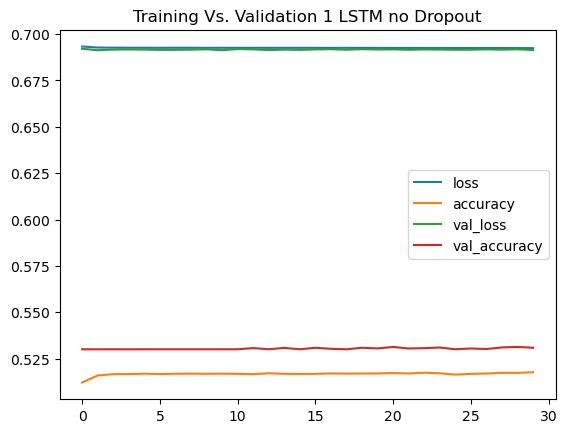

In [244]:
# Train vs test for loss
plt.plot(model_01.history["loss"])
plt.plot(model_01.history["accuracy"])
plt.plot(model_01.history["val_loss"])
plt.plot(model_01.history["val_accuracy"])
plt.title("Training Vs. Validation 1 LSTM no Dropout")
plt.legend(["loss", "accuracy","val_loss","val_accuracy"])
plt.show()